In [1]:
# limit for combination higgs
import ROOT as rt
# import root_numpy as rtnp
import csv
import re
import sys
import collections
import os
from collections import OrderedDict
import uproot
import pandas as pd
from array import array
import scipy
import awkward
import numpy as np
import time
import numba
from numba import jit
from matplotlib import pyplot as plt
sys.path.append('/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')
from histo_utilities import create_TH1D, create_TH2D, std_color_list, create_TGraph, make_ratio_plot
from limit_plots import *

import math
import CMS_lumi, tdrstyle
tdrstyle.setTDRStyle()
import importlib
print(sys.version)

Welcome to JupyROOT 6.18/02
3.6.8 (default, Aug  7 2019, 17:28:10) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-39)]


# Load ntuples

In [2]:
limitTrees =OrderedDict()
dataCards = OrderedDict()

limitTrees_obs =OrderedDict()
dataCards_obs = OrderedDict()
limitTrees_hybridNew = OrderedDict()

                 
samples = [
'300_100',
'300_75',
'500_100',
'500_275',
'700_100',
'700_475',
'900_100',
'900_675',
'1100_100',
'1100_875',
'1300_100',
'1300_1075',
# '1500_100': [1,10,100,1000],
# '1500_1275': [1,10,100,1000],

]

modes = ['StealthSYY', 'StealthSHH']

version = 'V1p17/v2/v198//cut_based_v4/v19/methodB/unblind/'
limitDir = '/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine/limitTrees/' + version + '/'
dataCardDir = limitDir.replace("limitTrees","datacards")


unblind = 'unblind'

ctaus = np.array([30, 100, 300, 1000, 3000, 10000, 30000, 100000]) 

ctaus = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, \
                  20, 30, 40, 50, 60, 100, 125, 150, 200, 300, 500, 600,700,800, \
                  1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, \
                  10000, 20000, 30000, 50000, 60000, 70000, 80000, 90000,
                  100000,200000, 300000, 500000, 600000, 700000, 800000, 900000,\
                        int(1e6), int(2e6),int(3e6),int(5e6), int(6e6), int(7e6), int(8e6), int(9e6), 9750000, int(1e7)]) #v12


# ctaus = np.array([0.1,1,10,100,1000,10000])
### limit branch: 2.5, 16.0, 50.0, 84.0, 97.5, obs
expected = ['0.025', '0.160','0.500','0.840','0.975']


                
for m in samples:
    for d in modes:
        key = d + '_' + m
        limitTrees[key] = {}
        dataCards[key] = {}

        for ct in ctaus:
            ct_str = str(ct).replace('.','p') if ct < 1 else str(int(round(ct)))
            dataCards[key][ct] = dataCardDir + key + '_' + ct_str + '.txt'
            limitTrees[key][ct] = limitDir + '/higgsCombine.'+ key + '_'  + ct_str + '.AsymptoticLimits.mH120.root'             
norms = []
limits = {}
for i,m in enumerate(limitTrees.keys()):
    if unblind == 'blind' or unblind == 'unblindABC': limits[m] = np.ones((len(ctaus), 5))*1000000
    else:limits[m] = np.ones((len(ctaus), 6))*1000000
    for j, k in enumerate(limitTrees[m].keys()):
        if not os.path.isfile(dataCards[m][k]):
            
#             print(dataCards[m][k])
            continue
        
        line = open(dataCards[m][k], "r").readline()
        if not line.split(" ")[0] == '#' :continue
        signal_norm = float(line.split(" ")[3])
        
        if signal_norm == 0:continue
        if not os.path.isfile(limitTrees[m][k]):
            print(limitTrees[m][k])
            continue 
        if len(uproot.open(limitTrees[m][k]).keys()) == 2:
            T = uproot.open(limitTrees[m][k])['limit']                
            if len(np.array(T.array('limit')))>4:limits[m][j] = np.array(T.array('limit'))/signal_norm
    limits[m] = np.array(limits[m])
print(ctaus)

[       1        2        3        4        5        6        7        8
        9       10       11       12       13       14       15       16
       17       18       19       20       30       40       50       60
      100      125      150      200      300      500      600      700
      800     1000     2000     3000     4000     5000     6000     7000
     8000    10000    20000    30000    50000    60000    70000    80000
    90000   100000   200000   300000   500000   600000   700000   800000
   900000  1000000  2000000  3000000  5000000  6000000  7000000  8000000
  9000000  9750000 10000000]


In [3]:
print(ctaus)

[       1        2        3        4        5        6        7        8
        9       10       11       12       13       14       15       16
       17       18       19       20       30       40       50       60
      100      125      150      200      300      500      600      700
      800     1000     2000     3000     4000     5000     6000     7000
     8000    10000    20000    30000    50000    60000    70000    80000
    90000   100000   200000   300000   500000   600000   700000   800000
   900000  1000000  2000000  3000000  5000000  6000000  7000000  8000000
  9000000  9750000 10000000]


In [4]:

def find_intersect(graph1,y):
    ctaus_return = []
    ctaus = np.logspace(-2,4,1000)
    diff = []
    for x in ctaus:
        diff.append(graph1.Eval(x)-y)
    diff = np.sign(np.array(diff))
    for i in range(len(diff)):
        if i == len(diff)-1:continue
        if not diff[i] == diff[i+1]:
            ctaus_return.append(ctaus[i])
    return ctaus_return

In [5]:
print(dataCardDir)

##### save to ROOT file ######
outputDir = '/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_9_4_4/src/llp_analyzer/data/SupplementaryMaterials/EXO-21-008/'+version+'/'



/storage/af/user/christiw/login-1/christiw/LLP/CMSSW_10_2_13/src/HiggsAnalysis/MuonSystemLimit/combine/datacards/V1p17/v2/v198//cut_based_v4/v19/methodB/unblind//


In [6]:
xsec = {
    300:10.00, 
    500:0.609, 
    700:0.0783, 
    900:0.0145, 
    1100:0.00335, 
    1300:0.000887, 
    1500:0.000257}


In [82]:

def log_scale_conversion(h):

    ##########################
    # convert x to 10^^x
    ###########################

    oldX = []
    for i_bin in range(1, h.GetNbinsX()+1):
        oldX.append(h.GetXaxis().GetBinLowEdge(i_bin))
    oldX.append(h.GetXaxis().GetBinUpEdge(h.GetNbinsX()))

    oldY = []
    for i_bin in range(1, h.GetNbinsY()+1):
        oldY.append(h.GetYaxis().GetBinLowEdge(i_bin))
    oldY.append(h.GetYaxis().GetBinUpEdge(h.GetNbinsY()))

    myX = 10**np.array(oldX)
    myY = np.array(oldY)
    h_new = rt.TH2D('', '', len(myX)-1, array('f',myX), len(myY)-1, array('f', myY))
    for i in range(1, h.GetNbinsX()+1):
        for j in range(1, h.GetNbinsY()+1):
            h_new.SetBinContent(i,j,h.GetBinContent(i,j))
    for i in range(h_new.GetXaxis().GetNbins()):
        for j in range(h_new.GetYaxis().GetNbins()):
            if math.isnan(h_new.GetBinContent(i+1,j+1)):
                h_new.SetBinContent(i+1,j+1,100000)
    h_new.GetXaxis().SetTitle(h.GetXaxis().GetTitle())
    h_new.GetYaxis().SetTitle(h.GetYaxis().GetTitle())
    h_new.GetZaxis().SetTitle(h.GetZaxis().GetTitle())
    return h_new

['StealthSYY_300_100', 'StealthSYY_500_100', 'StealthSYY_700_100', 'StealthSYY_900_100', 'StealthSYY_1100_100', 'StealthSYY_1300_100'] SYY 100
['StealthSYY_300_75', 'StealthSYY_500_275', 'StealthSYY_700_475', 'StealthSYY_900_675', 'StealthSYY_1100_875', 'StealthSYY_1300_1075'] SYY heavy
['StealthSHH_300_100', 'StealthSHH_500_100', 'StealthSHH_700_100', 'StealthSHH_900_100', 'StealthSHH_1100_100', 'StealthSHH_1300_100'] SHH 100
['StealthSHH_300_75', 'StealthSHH_500_275', 'StealthSHH_700_475', 'StealthSHH_900_675', 'StealthSHH_1100_875', 'StealthSHH_1300_1075'] SHH heavy
['StealthSYY_300_100', 'StealthSYY_500_100', 'StealthSYY_700_100', 'StealthSYY_900_100', 'StealthSYY_1100_100', 'StealthSYY_1300_100'] SYY 100
['StealthSYY_300_75', 'StealthSYY_500_275', 'StealthSYY_700_475', 'StealthSYY_900_675', 'StealthSYY_1100_875', 'StealthSYY_1300_1075'] SYY heavy
['StealthSHH_300_100', 'StealthSHH_500_100', 'StealthSHH_700_100', 'StealthSHH_900_100', 'StealthSHH_1100_100', 'StealthSHH_1300_100'] S

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TGraph2D: Graph2D (Potential memory leak).
Warning in <TCanvas::Constructor>: Deleting canv

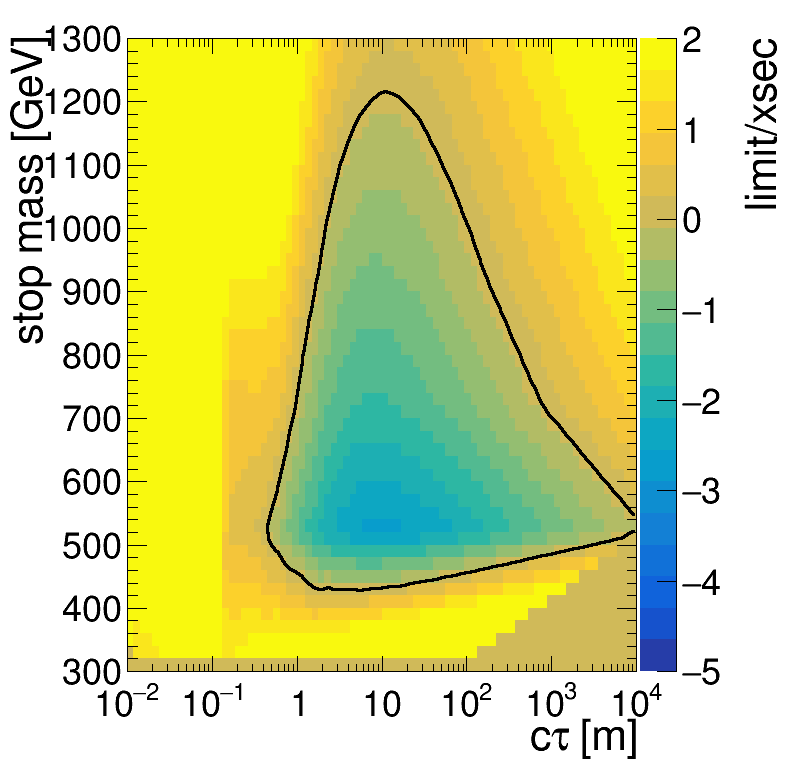

In [87]:
sys.path.append('/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/lib/')


importlib.reload(sys.modules['limit_plots'])

ctaus_m = ctaus/1000
for exp_flag in [0,1]:
    for mode in ['SYY', 'SHH']:
        for mass in ['100', 'heavy']:
#             if not mass == 'heavy':continue
#             if not mode == 'SYY':continue
            c = rt.TCanvas('c','c', 800, 800)
            c.SetRightMargin(0.04)
            h = create_TH2D(np.column_stack((np.array(0), np.array(0))), axis_title = ['stop mass [GeV]','c#tau [m]','limit/xsec'], \
                    binning = [50,300,1300,100,-2,4])
            
            h = create_TH2D(np.column_stack((np.array(0), np.array(0))), axis_title = ['c#tau [m]','stop mass [GeV]','limit/xsec'], \
                    binning = [80,-2,4, 50,300,1300])
            x = array('d',[])
            y = array('d',[])
            z = array('d',[])
#             for i in range(h.GetXaxis().GetNbins()):
#                 for j in range(h.GetYaxis().GetNbins()):
#                     h.SetBinContent(i+1,j+1,100000)

            limits_keys = []
            for k in limits.keys():
                if mode in k:
                    if mass == '100' and k[-4:] == '_100':limits_keys.append(k)
                    elif mass == 'heavy' and not k[-4:] == '_100':limits_keys.append(k)
            print(limits_keys, mode, mass)
            for m in limits_keys:
                cond = limits[m][:,2] < 1000000
                if '_100' in m:
                    cond = np.logical_and(cond, np.logical_not(np.logical_and(ctaus_m>0.1, ctaus_m<1)))
                if np.count_nonzero(cond) == 0:continue
                    
                    
                for j in range(len(ctaus_m[cond])):
#                     x.append(math.log10(float(m.split('_')[1])))
#                     y.append(math.log10(ctaus_m[cond][j]))
#                     if exp_flag:z.append(math.log10(limits[m][:,2][cond][j]/xsec[int(m.split('_')[1])]))
#                     else: z.append(math.log10(limits[m][:,5][cond][j]/xsec[int(m.split('_')[1])]))
                        
                    x.append(math.log10(ctaus_m[cond][j]))
                    y.append(float(m.split('_')[1]))
                    if exp_flag:
                        z.append(math.log10(limits[m][:,2][cond][j]/xsec[int(m.split('_')[1])]))
                        h.SetBinContent(h.GetXaxis().FindBin(math.log10(ctaus_m[cond][j])), \
                                    h.GetYaxis().FindBin(float(m.split('_')[1])),math.log10(limits[m][:,2][cond][j]/xsec[int(m.split('_')[1])]))

                    else: 
                        z.append(math.log10(limits[m][:,5][cond][j]/xsec[int(m.split('_')[1])]))
                        h.SetBinContent(h.GetXaxis().FindBin(math.log10(ctaus_m[cond][j])), \
                                    h.GetYaxis().FindBin(float(m.split('_')[1])),math.log10(limits[m][:,5][cond][j]/xsec[int(m.split('_')[1])]))
            graph = rt.TGraph2D(len(x), x, y, z)
        
#             h = interpolate2D(x,y,z, h, 0.02,0.01)
            for i in range(h.GetXaxis().GetNbins()):
                for j in range(h.GetYaxis().GetNbins()):
                    h.SetBinContent(i+1,j+1,graph.Interpolate(h.GetXaxis().GetBinCenter(i), h.GetYaxis().GetBinCenter(j)))
            tdrstyle.setTDRStyle()    

            #############
            # plot contour
            #############

            contours = array('d',[0.0])
            hframed = frameTH2D(h)
            hframed = h.Clone()

            hframed = log_scale_conversion(hframed)

            hframed.SetContour(len(contours),contours)
            hframed.SetMaximum(2)
            hframed.SetMinimum(-5)
            hframed.Draw("CONT Z LIST")

            rt.gPad.Update()

            h = log_scale_conversion(h)

            h.SetMinimum(-5)
            h.SetMaximum(2) 
            h.GetZaxis().SetTitleOffset(1.1)

            h.GetXaxis().SetLabelOffset(0.0)

            h.Draw('colz')


            conts = rt.gROOT.GetListOfSpecials().FindObject("contours")
            cont_gr = []
            for i in range(conts.GetSize()):
                contour0 = conts.At(i)
                curv = contour0.First()
                finalcurv = rt.TGraph(1)
                try:
                    curv.SetLineWidth(3)
                    curv.SetLineColor(std_color_list[0])
                    curv.SetLineStyle(std_color_list[i])

                    curv.Draw("lsame")
                    finalcurv = curv.Clone()
                    maxN = curv.GetN()
                    for i in range(1, contour0.GetSize()):
                        curv = contour0.After(curv)
                        curv.SetLineWidth(3)
                        curv.SetLineColor(rt.kBlack)
                        curv.Draw("lsame")
                        if curv.GetN()>maxN:
                            maxN = curv.GetN()
                            finalcurv = curv.Clone()
                    cont_gr.append(finalcurv)
                except AttributeError:
                    print ("ERROR: no curve drawn for contour %s "%(i))
            for idex in range(len(cont_gr)):
                i = len(cont_gr)-idex-1
#                 leg.AddEntry(cont_gr[i],'B(h #rightarrow SS) = '+str(contours[len(contours)-idex-1]), 'L')
                finalcurv.Draw('lsame')
                finalcurv.GetXaxis().SetTitle('c#tau[m]')
                finalcurv.GetYaxis().SetTitle('mstop [GeV]')
                ### save to ROOT file ###

                if not os.path.isfile(outputDir+'limits_stealthSUSY_smooth.root'):outFile = rt.TFile(outputDir+'limits_stealthSUSY_smooth.root', 'RECREATE')
                else: outFile = rt.TFile(outputDir+'limits_stealthSUSY_smooth.root', 'UPDATE')
                name = mode + '_' + mass
                if exp_flag: name += '_' + 'exp'
                else: name += '_' + 'obs'
                outFile.WriteTObject(finalcurv, name, "WriteDelete");
                outFile.Close();

            c.SetRightMargin(0.2)
#             c.SetLogz()
            c.SetLogx()
            c.Draw()


# Expected Limit only (blinded)

In [ ]:
import os
import importlib
importlib.reload(sys.modules['CMS_lumi'])


exp = {
    'SHH_100_lower':[],
    'SHH_heavy_lower':[],
    'SYY_100_lower':[],
    'SYY_heavy_lower':[],
    
    'SHH_100_upper':[],
    'SHH_heavy_upper':[],
    'SYY_100_upper':[],
    'SYY_heavy_upper':[],
}
obs = {
    'SHH_100_lower':[],
    'SHH_heavy_lower':[],
    'SYY_100_lower':[],
    'SYY_heavy_lower':[],
    
    'SHH_100_upper':[],
    'SHH_heavy_upper':[],
    'SYY_100_upper':[],
    'SYY_heavy_upper':[],
}
opac_1sig = 0.25
opac_2sig = 0.1
leg = rt.TLegend(0.45,0.15,0.93,0.27)
leg2 = rt.TLegend(0.17,0.17,0.40,0.27)
leg.SetTextSize(0.03)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
leg2.SetTextSize(0.03)
leg2.SetBorderSize(0)
leg2.SetEntrySeparation(0.01)
c = rt.TCanvas('c','c', 800, 800)
c.SetRightMargin(0.04)

rt.gStyle.SetOptFit(1011)
ctaus_m = ctaus/1000
#     print(ctaus_m)
h = {}
h_exp1sig = {}
h_exp2sig = {}
h_obs = {}
h_others = {}

i = 0
for m in limits.keys():
#     if not '1100' in m:continue
    
#     if not 'SHH' in m:continue

    cond = limits[m][:,2] < 1000000
    if '_100' in m:
        cond = np.logical_and(cond, np.logical_not(np.logical_and(ctaus_m>0.1, ctaus_m<1)))
    if np.count_nonzero(cond) == 0:continue

    h[m] = create_TGraph(ctaus_m[cond], limits[m][:,2][cond],  axis_title=['c#tau [m]', ''])
    h_obs[m] = create_TGraph(ctaus_m[cond], limits[m][:,5][cond],  axis_title=['c#tau [m]', ''])
    h_exp1sig[m] = create_TGraph(np.hstack((ctaus_m[cond], np.flip(ctaus_m[cond]))), np.hstack((limits[m][:,1][cond], np.flip(limits[m][:,3][cond]))))

    print(m, find_intersect(h[m],xsec[int(m.split('_')[1])]))
    intersect = find_intersect(h[m],xsec[int(m.split('_')[1])])
    print(intersect)
    key = ''
    if 'SHH' in m:key += 'SHH_'
    else: key += 'SYY_'
    if m[-4:] == '_100': key += '100_'
    else: key += 'heavy_'
    if len(intersect)==2:            
        exp[key + 'lower'].append((int(m.split('_')[1]), intersect[0]))
        exp[key + 'upper'].append((int(m.split('_')[1]), intersect[1]))
    intersect = find_intersect(h_obs[m],xsec[int(m.split('_')[1])])
    key = ''
    if 'SHH' in m:key += 'SHH_'
    else: key += 'SYY_'
    if m[-4:] == '_100': key += '100_'
    else: key += 'heavy_'
    if len(intersect)==2:            
        obs[key + 'lower'].append((int(m.split('_')[1]), intersect[0]))
        obs[key + 'upper'].append((int(m.split('_')[1]), intersect[1]))
        
 
    
    h_obs[m].GetYaxis().SetTitle('95% CL limit on #sigma [pb]')
#     h_exp1sig[m].SetFillColorAlpha(std_color_list[i],opac_1sig)
#     h[m].SetLineColor(std_color_list[i])
#     h[m].SetMarkerColor(std_color_list[i])
#     h_obs[m].SetLineWidth(3)
#     h_obs[m].SetLineColor(std_color_list[i])
#     h_obs[m].SetMarkerColor(std_color_list[i])
    h_obs[m].SetMarkerStyle(8)

    h[m].SetLineWidth(3)
    h[m].SetLineStyle(2)
    h_obs[m].SetLineStyle(1)
    h[m].SetLineWidth(3)


#         leg.AddEntry(h_obs[m], "(m_{{H}}, m_{{X}}) = ({},{}) GeV".format(mh,mx), "L")

    leg.AddEntry(h_obs[m], m, "L")

    if h[m].GetLineColor()==1:
        leg2.AddEntry(h[m], "Median Expected", "L")
        leg2.AddEntry(h_obs[m], "Observed", "L")
    leg.AddEntry(h_exp1sig[m], "#pm 1 #sigma Expected", 'F')


    h_obs[m].GetXaxis().SetLimits(0.01,10000.0)
    h_obs[m].GetYaxis().SetRangeUser(1e-4,10)

    h_obs[m].GetXaxis().SetTitleOffset(1)
    h_obs[m].GetYaxis().SetTitleSize(0.05)
    h_obs[m].GetYaxis().SetTitleOffset(1.5)
    i+=1

    ### save to ROOT file ###
#             if not os.path.isfile(outputDir+'limits_zPrime.root'):outFile = rt.TFile(outputDir+'limits_zPrime.root', 'RECREATE')
#             else: outFile = rt.TFile(outputDir+'limits_zPrime.root', 'UPDATE')
#             outFile.WriteTObject(h[m], 'h_'+m+'_exp', "WriteDelete");
#             outFile.WriteTObject(h_obs[m], 'h_'+m+'_obs', "WriteDelete");
#             outFile.WriteTObject(h_exp1sig[m], 'h_'+m+'_exp1sig', "WriteDelete");
#             outFile.Close();
for i,m in enumerate(h.keys()):
    h_obs[m].Draw('PLA' if i == 0 else 'PLsame')
    h[m].Draw('LPsame')
    h_exp1sig[m].Draw('FSame')



tdrstyle.setTDRStyle()
CMS_lumi.cmsText     = "CMS"
iPos = 0
CMS_lumi.writeExtraText = 1
CMS_lumi.extraText   = "Preliminary"

if( iPos==0 ): CMS_lumi.relPosX = 0.12
CMS_lumi.relExtraDX =0.0
CMS_lumi.CMS_lumi(c, 4, iPos)


leg.SetNColumns(2)

leg.Draw()
leg2.Draw()
c.SetLogy()
c.SetLogx()
c.SetTicky(1)
c.SetTickx(1)


output_dir = '/storage/af/user/christiw/gpu/christiw/llp/delayed_jet_analyzer/plots/MuonSystem_Analysis/double_tag/combined_limits/'+version +'/'
if not os.path.isdir(output_dir):os.makedirs(output_dir)
#     print(name)

#         if CMS_lumi.writeExtraText:
#             c.SaveAs(output_dir + model + '_'+d+'_'+str(mh_leg)+'_observed_pas.png')
#             c.SaveAs(output_dir + model + '_'+d+'_'+str(mh_leg)+'_observed_pas.pdf')
#             c.SaveAs(output_dir + model + '_'+d+'_'+str(mh_leg)+'_observed_pas.C')




tdrstyle.setTDRStyle()
c.Draw()



In [ ]:
for exp_flag in [0,1]:
    for mode in ['SYY', 'SHH']:
        for mass in ['100', 'heavy']:
#             if not mass == 'heavy':continue
#             if not mode == 'SYY':continue
            c = rt.TCanvas('c','c', 800, 800)
            c.SetRightMargin(0.04)

            rt.gStyle.SetOptFit(1011)
            plot_dict = []
            x = []
            y = []
            if exp_flag: 
                for i,j in exp[mode + '_' + mass + '_lower']:
                    x.append(i)
                    y.append(j)
                for i in range(len(exp[mode + '_' + mass + '_upper'])-1,-1,-1):
                    x.append(exp[mode + '_' + mass + '_upper'][i][0])
                    y.append(exp[mode + '_' + mass + '_upper'][i][1])
            else: 
                for i,j in obs[mode + '_' + mass + '_lower']:
                    x.append(i)
                    y.append(j)
                for i in range(len(obs[mode + '_' + mass + '_upper'])-1,-1,-1):
                    x.append(obs[mode + '_' + mass + '_upper'][i][0])
                    y.append(obs[mode + '_' + mass + '_upper'][i][1])
            print(exp_flag, mode, mass, x,y)
            if len(y) == 0:continue
            h = create_TGraph(y,x,  axis_title=['ctau [m]','mass'])
            h.SetLineWidth(3)
            h.SetMarkerStyle(8)
            h.Draw('LAP')
            ### save to ROOT file ###

            if not os.path.isfile(outputDir+'limits_stealthSUSY.root'):outFile = rt.TFile(outputDir+'limits_stealthSUSY.root', 'RECREATE')
            else: outFile = rt.TFile(outputDir+'limits_stealthSUSY.root', 'UPDATE')
            name = mode + '_' + mass
            if exp_flag: name += '_' + 'exp'
            else: name += '_' + 'obs'
            outFile.WriteTObject(h, name, "WriteDelete");
            outFile.Close();


            c.SetLogx()
            c.Draw()

In [ ]:
list(range(5,0,-1))